# Simulations to assign enrichment statistics (`fig-suppl-enrichment-pvalue`)

In [1]:
import os

# change working directory to `./panning-massive` for simplicity of access to feature tables, etc
# make sure we don't do this twice, or we'll end up in the wrong place and be very confused
if 'dir_changed' not in globals():
    os.chdir('../../')
    dir_changed = True

In [2]:
import os.path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

import plotnine
from plotnine import *
from IPython.display import Markdown, HTML

In [3]:
import nbseq
import nbseq.ft
import nbseq.viz.sample
from nbseq.viz.utils import extract_encoded_data_plotnine

In [4]:
plt.rcParams.update({
    "font.family":"sans",
    "font.size": 6,
    "svg.fonttype":"none",
})

FONT_SIZE = 5

In [5]:
%config InlineBackend.figure_formats = ['svg']

***

Load data

In [6]:
ex = nbseq.Experiment.from_files(ft_aa=None,
                                 tree_cdr3=None, tree_aa=None) #'intermediate/cdr3/features/all/alpaca/asvs.nwk')

Loading experiment panning-massive from '/vast/palmer/home.mccleary/cng2/code/phageseq-paper/panning-massive'...
- Reading metadata from config/metadata_full.csv ...
- Reading phenotypes from config/phenotypes.csv ...
- Reading Config from config/config.yaml ...
- Warning: sqlite database '/vast/palmer/home.mccleary/cng2/code/phageseq-paper/panning-massive/intermediate/aa/asvs.db' does not exist
- Reading feature data for table 'cdr3' from results/tables/cdr3/asvs.csv (3.8 MB)...
- Reading cdr3 feature table from results/tables/cdr3/feature_table.biom (29.0 MB)...
- Warning: mmseqs2 database for space 'aa' at 'intermediate/aa/features_db/features' does not exist!
- Warning: mmseqs2 database for space 'cdr3' at 'intermediate/cdr3/features_db/features' does not exist!
- Reading enrichment model (conditional ECDF) for space cdr3 from results/tables/cdr3/enrichment/null/ecdf.pickle (307.6 kB)...
Finished in 0.70 seconds


In [7]:
ex

Experiment('panning-massive') with feature spaces ['cdr3']:
  obs: ['plate' 'well' 'depth' 'expt' 'round' 'sample' 'phage_library' 'notes'
    'r' 'io' 'kind' 'selection' 'replicate' 'name_full' 'name' 'well_027e'
    'sel_plate' 'sel_well' 'category' 'antigen' 'genotype_pair' 'gene_CS'
    'gene_S' 'genotype_CS' 'background_CS' 'strain_CS' 'loc_CS' 'cond_CS'
    'genotype_S' 'background_S' 'strain_S' 'loc_S' 'cond_S' 'cond_notes'  'bflm'
    'swim' 'twitch' 'swarm' 'PMB-R' 'FEP-R' 'TET-R' 'CIP-R' 'CHL-R'  'GEN-R'
    'ERY-R' 'IPM-R' 'cdiGMP' 'FliC' 'FliCa' 'FliCb' 'FlgEHKL' 'PilQ'  'PilA'
    'PilB' 'LasA' 'LasB' 'Apr' 'XcpQ' 'ToxA' 'EstA' 'LepA' 'PlpD'  'Phz' 'Pcn'
    'Pvd' 'Hcn' 'Rhl' 'T3SS' 'T6SS' 'Pel' 'Psl' 'CdrB' 'SCV'  'Mucoid'
    'Alginate' 'OprM' 'OprJ' 'OprN' 'OprP' 'OpdH' 'OprD' 'OprL'  'OprF' 'OprG'
    'OprH' 'OprB' 'MexAB' 'MexCD' 'MexEF' 'MexJK' 'MexXY'  'MexGHI' 'PirA' 'Pfu'
    'TonB' 'FptA' 'FpvA' 'PfeA' 'CupB5' 'CupA' 'CupB'  'CupC' 'CupD' 'LPS-
    LipidA-Palmito

Separate samples where library was resequenced based on whether they were passaged, reprecipitated, or both

In [8]:
lib_sample = ex.obs.loc[ex.obs.expt == '027i.lib','sample']
ex.obs.loc[ex.obs.expt == '027i.lib','library_passage'] = lib_sample.apply(lambda x: ('P2' if 'P2' in x else 'P1'))
ex.obs.loc[ex.obs.expt == '027i.lib','library_precip']  = lib_sample.apply(lambda x: ('reprecipitated' if 'reprecip' in x else 'raw'))
ex.obs.loc[ex.obs.expt == '027i.lib','library_class']   = ex.obs.loc[ex.obs.expt == '027i.lib','library_passage'] + ' ' + ex.obs.loc[ex.obs.expt == '027i.lib','library_precip'] 

ex.fts.cdr3.obs = ex.obs

In [9]:
ft_lib_cdr3 = ex.query("expt == '027i.lib'", space='cdr3', axis='obs')

ft_lib_cdr3_P1 = ex.query("expt == '027i.lib' & library_passage == 'P1'", space='cdr3', axis='obs')
ft_lib_cdr3_P2 = ex.query("expt == '027i.lib' & library_passage == 'P2'", space='cdr3', axis='obs')

## Raw Library barplot

In [10]:
def top_asv_barplot(ex, query, space='cdr3', n=30, select_from_round=4, phylo=False, **kwargs):
    samples = ex.query_ids(f"({query}) & kind =='+' & io == 'i'", space=space)
    if select_from_round is not None:
        top_from_samples = ex.query_ids(f"({query}) & r == {select_from_round} & kind =='+' & io == 'i'", space=space)
    else:
        top_from_samples = None
    
    
    ft_top = nbseq.viz.sample.collapse_top_asvs(ex.fts[space], samples, top_from_samples = top_from_samples, n=n)
    df = nbseq.ft.fortify(ft_top, obs=True, relative=True)
    
    if phylo:
        return nbseq.viz.sample.top_asv_plot_phylo(df, ex.tree[space], **kwargs)
    else: 
        return nbseq.viz.sample.top_asv_barplot(df, **kwargs)

Plot library

In [11]:
%%bash
mkdir -p results/plots/null_model/
mkdir -p results/tables/figures/null_model/

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.



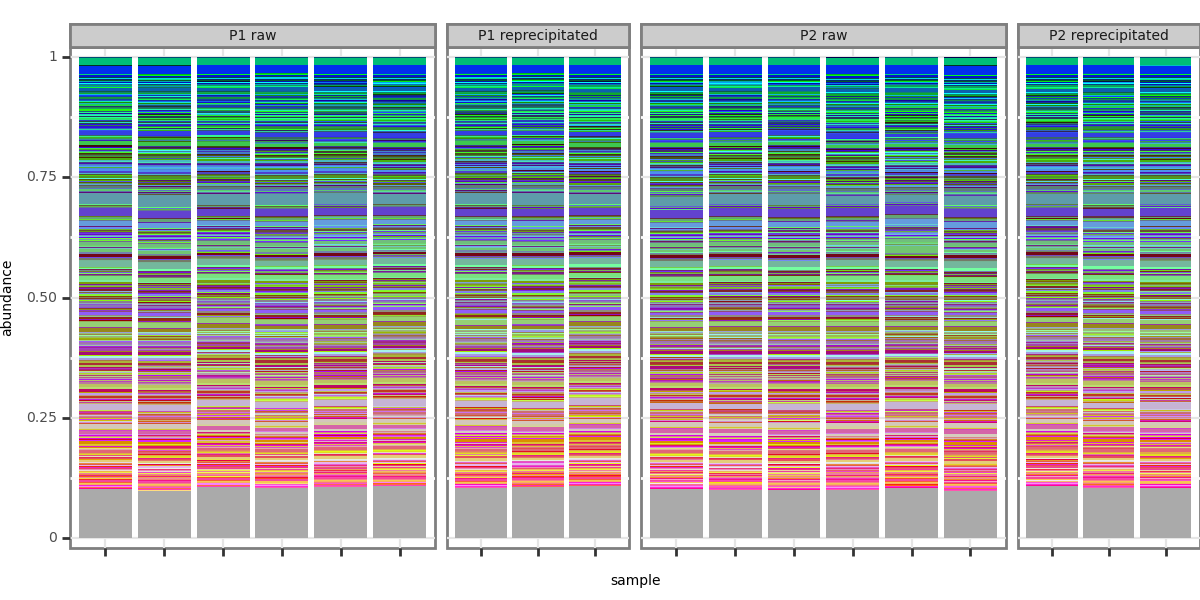

<Figure Size: (600 x 300)>

In [12]:
gg = (top_asv_barplot(ex, "expt == '027i.lib'", x='name_full', select_from_round=None, n=1000) 
 + facet_grid(('.','library_class'), scales='free_x', space={'x':[6,3,6,3]})
 + scale_y_continuous(name="abundance", expand=(0.01,0.01))
 + scale_x_discrete(name='sample')
 + theme_bw()
 + theme(
     figure_size=(6,3),
     legend_position='none',
     text=element_text(family='sans', size=5),
     axis_text_x=element_blank(),
     plot_margin=0, 
 )
)
gg

In [13]:
df = extract_encoded_data_plotnine(gg)
df.rename(columns={'library_class':'library', 'feature':'CDR3ID'}, inplace=True)
df.to_csv('results/tables/figures/null_model/library_barplot.csv', index=False)

In [14]:
gg.save("results/plots/null_model/library_barplot.svg")

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 3 in image.
/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: results/plots/null_model/library_barplot.svg


## Enrichment simulation for library amplification

Simulate sample enrichments, comparing only library samples from passage 1 to library samples from passage 2

In [15]:
df_enr_ampl = nbseq.select.simulate_enrichments(ft_lib_cdr3_P1, ft_lib_cdr3_P2)
df_enr_ampl['log_enrichment'] = np.log10(df_enr_ampl.enrichment).replace([float('inf'), float('-inf')],0)

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/nbseq/select/__init__.py:1549: RuntimeWarning: divide by zero encountered in divide


In [16]:
df_enr_ampl = df_enr_ampl.query("enrichment > 1")
df_enr_ampl_sub = df_enr_ampl.sample(100_000)

In [17]:
cond_ecdf_ampl = nbseq.select.enrichment_abundance_ecdf(df_enr_ampl_sub, plot=True, verbose=True, 
                                                   fig_kw=dict(figsize=(4,4)))

Fitting joint KDE...
Estimating joint probabilities on grid from KDE...
Fitting 2D spline to interpolate ECDF...


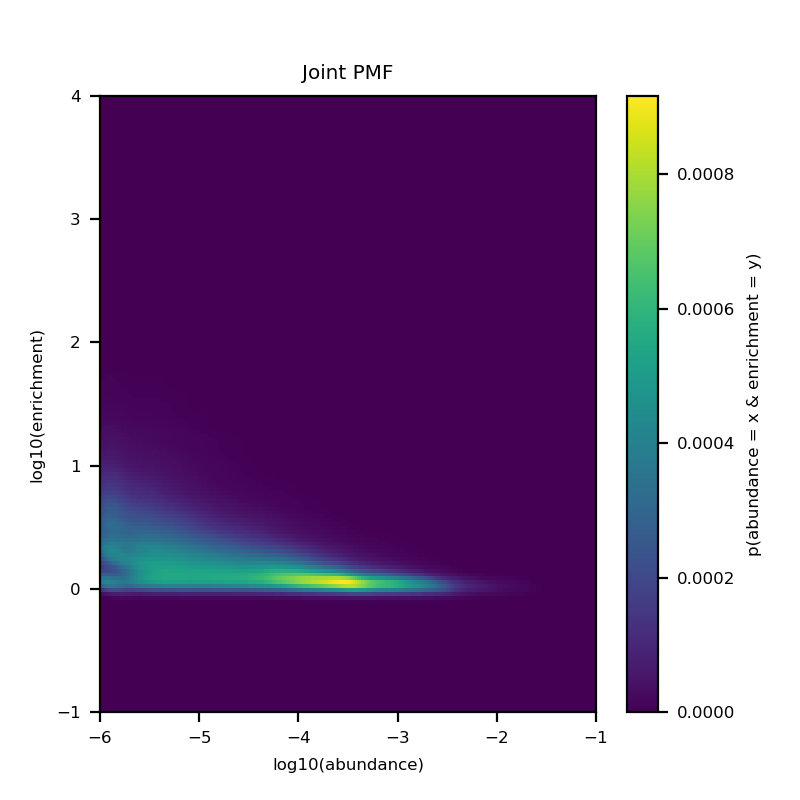

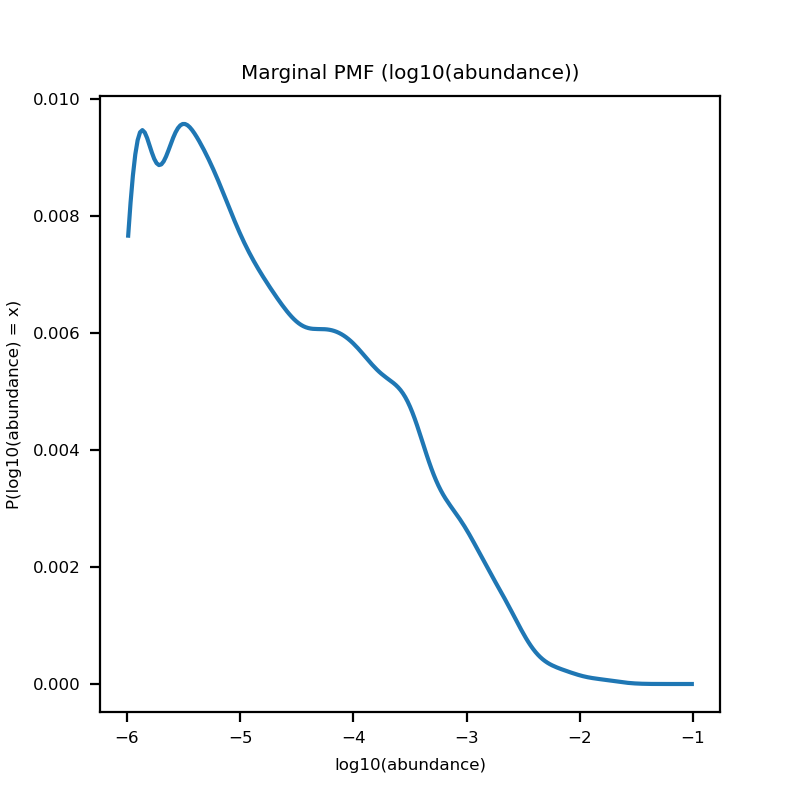

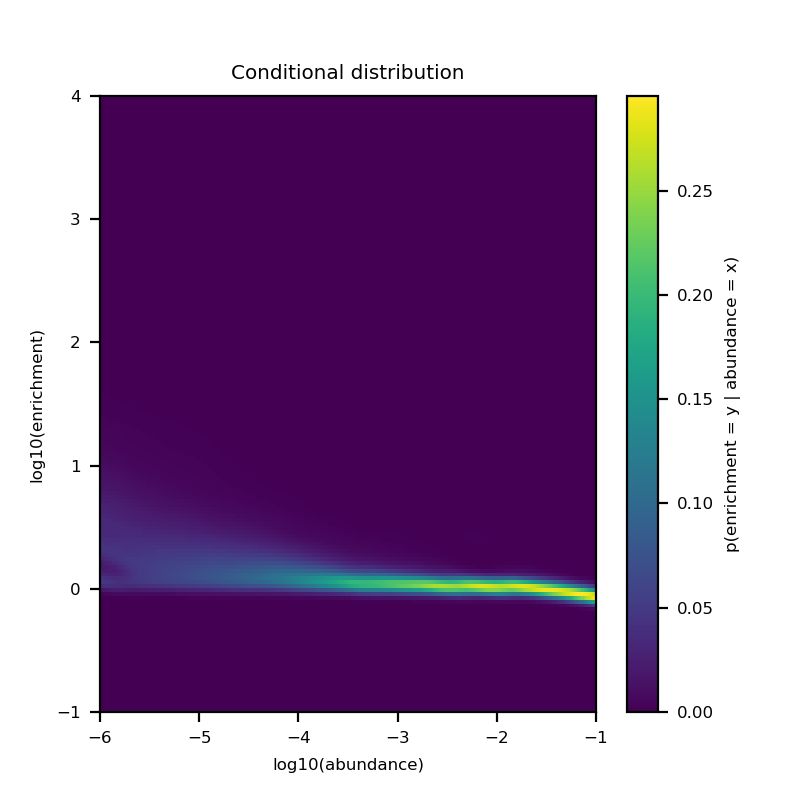

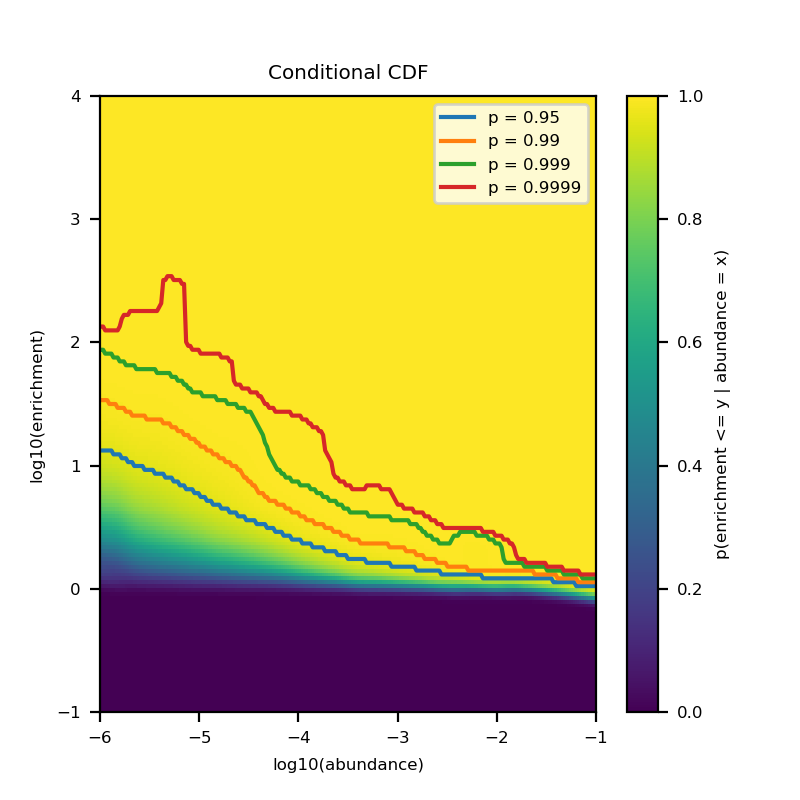

In [18]:
plt.show()

In [19]:
cond_ecdf_path = f'results/tables/cdr3/enrichment/null/ecdf_ampl.pickle'
nbseq.utils.mkdirp_file(cond_ecdf_path)
with open(cond_ecdf_path, 'wb') as f:
    import pickle
    pickle.dump(cond_ecdf_ampl, f)

## Enrichment simulation for full dataset

In [20]:
df_enr_sim = nbseq.select.simulate_enrichments(ft_lib_cdr3)
df_enr_sim['log_enrichment'] = np.log10(df_enr_sim.enrichment).replace([float('inf'), float('-inf')],0)

/gpfs/gibbs/project/kazmierczak/cng2/conda_envs/nbseq_full_dev_v1/lib/python3.10/site-packages/nbseq/select/__init__.py:1549: RuntimeWarning: divide by zero encountered in divide


Compare enrichment distribution of full dataset to amplified samples enrichment

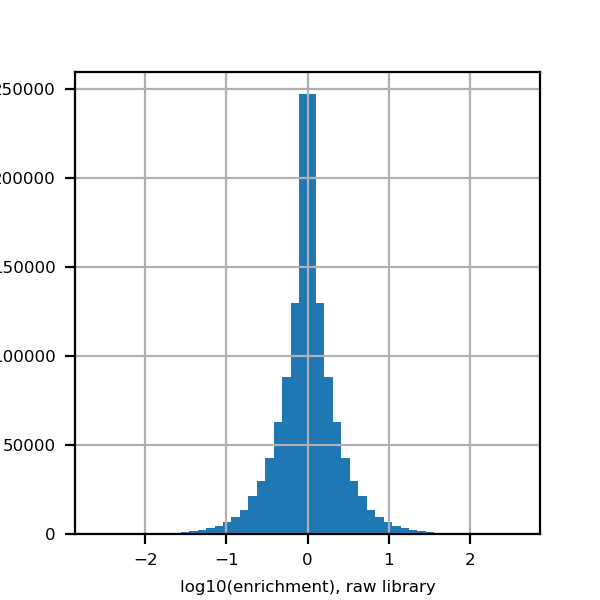

In [21]:
df_enr_sim['log_enrichment'].hist(figsize=(3,3),bins=50)
plt.xlabel('log10(enrichment), raw library');
plt.ylabel('count');
plt.show()
plt.savefig('results/plots/null_model/enrichments_marginal.svg')

In [22]:
values, bins, _ = plt.hist(df_enr_sim['log_enrichment'], bins=50)

bin_edges = []
bin_l = []
bin_r = []
for i in range(len(values)):
    bin_edges.append(f'[{bins[i]}, {bins[i+1]})')
    bin_l.append(bins[i])
    bin_r.append(bins[i+1])

pd.DataFrame({
    'log10(enrichment) bin lower bound': bin_l, 
    'log10(enrichment) bin upper bound': bin_r,
    'number of observations': values}).to_csv(
    'results/tables/figures/null_model/enrichments_marginal.csv', index=False)

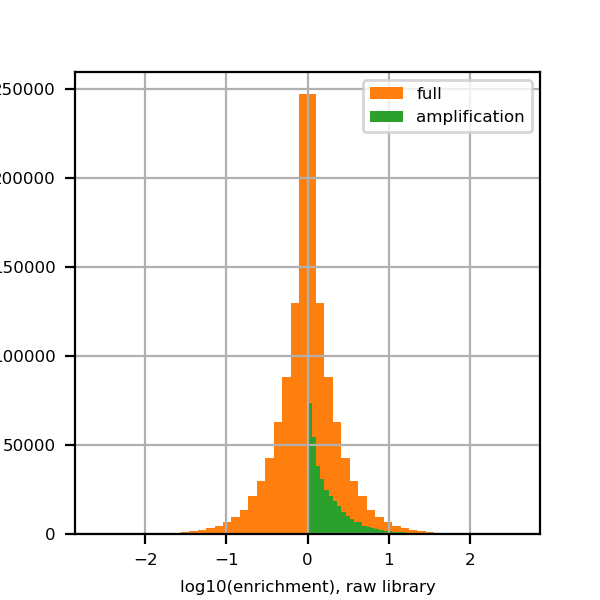

In [23]:
df_enr_sim['log_enrichment'].hist(figsize=(3,3),bins=50, label='full')
df_enr_ampl['log_enrichment'].hist(figsize=(3,3),bins=50, label='amplification')
plt.xlabel('log10(enrichment), raw library');
plt.ylabel('count');
plt.legend();
plt.savefig('results/plots/null_model/enrichments_marginal_full_vs_amplification.svg')
plt.show()

P(enrichment < 6.4) = 0.95
P(enrichment < 17) = 0.99
P(enrichment < 50) = 0.999


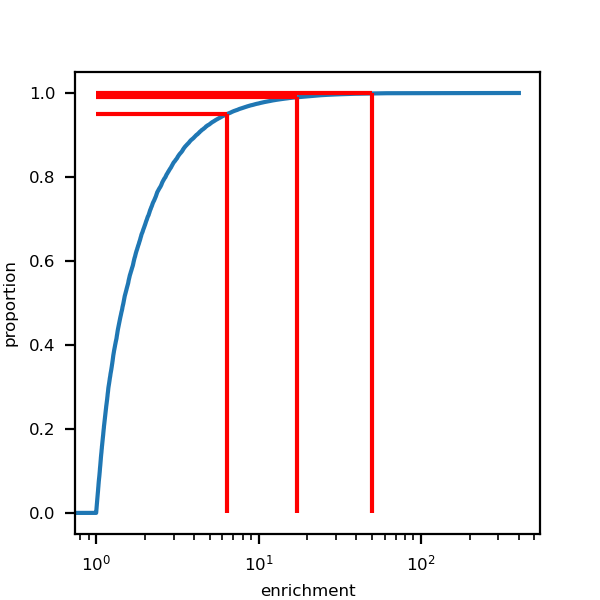

In [24]:
def ecdf_p_plot(xs, ps = [0.95, 0.99, 0.999], ax=None):

    from statsmodels.distributions.empirical_distribution import ECDF
    ecdf = ECDF(xs)

    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(ecdf.x, ecdf.y)
    plt.xscale('log')
    plt.xlabel(xs.name)
    plt.ylabel('proportion')
    # plt.axhline(0.95,c='red')
    
    xmin = min(xs)
    for p in ps:
        e_p = min(ecdf.x[ecdf.y > p])
        
        # plt.axhline(p,c='red')
        plt.hlines(y=p, xmin=xmin, xmax=e_p, color='red')
        plt.vlines(x=e_p, ymin=0, ymax=p, color='red')
        print(f"P({xs.name} < {e_p:0.2g}) = {p}")
    return ecdf

fig, ax = plt.subplots(figsize=(3,3))
ecdf = ecdf_p_plot(df_enr_sim.loc[df_enr_sim['enrichment'] > 1,'enrichment'], ax=ax)

plt.show()
plt.savefig('results/plots/null_model/enrichments_marginal_cdf.svg')

In [25]:
pd.DataFrame({'enrichment <= x':ecdf.x, 'proportion':ecdf.y}).to_csv(
    'results/tables/figures/null_model/enrichments_marginal_cdf.csv', index=False)

In [26]:
df_enr_sim = df_enr_sim.query("enrichment > 1")
df_enr_sim_sub = df_enr_sim.sample(100_000)

In [27]:
df_enr_sim_sub.rename(
    columns={
    'abundance': 'starting abundance', 
    'end_abundance': 'ending abundance', 
    'log_enrichment': 'log10(enrichment)'}
).to_csv(
    'results/tables/figures/null_model/abundance_vs_enrichment.csv', index=False)

<Figure size 640x480 with 0 Axes>

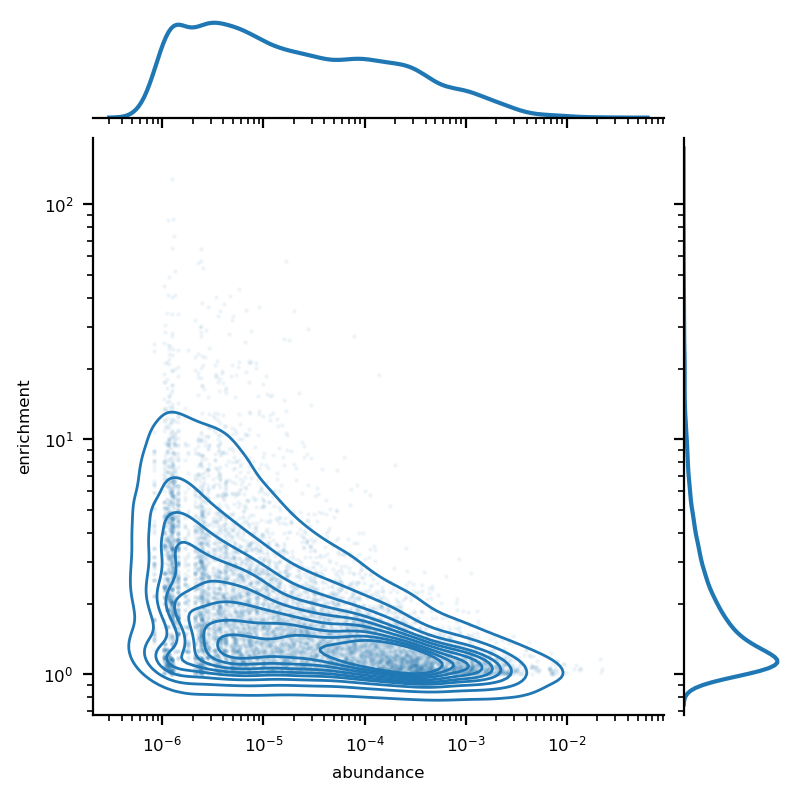

In [28]:
g = nbseq.select.abundance_enrichment_plot(df_enr_sim_sub, height=4, 
                                           linewidths=1, 
                                           scatter_kw=dict(s=2,marker='.'))
plt.show()
g.fig.savefig('results/plots/null_model/abundance_vs_enrichment.svg')

In [29]:
cond_ecdf = nbseq.select.enrichment_abundance_ecdf(df_enr_sim_sub, plot=True, verbose=True, 
                                                   fig_kw=dict(figsize=(4,4)))

Fitting joint KDE...
Estimating joint probabilities on grid from KDE...
Fitting 2D spline to interpolate ECDF...


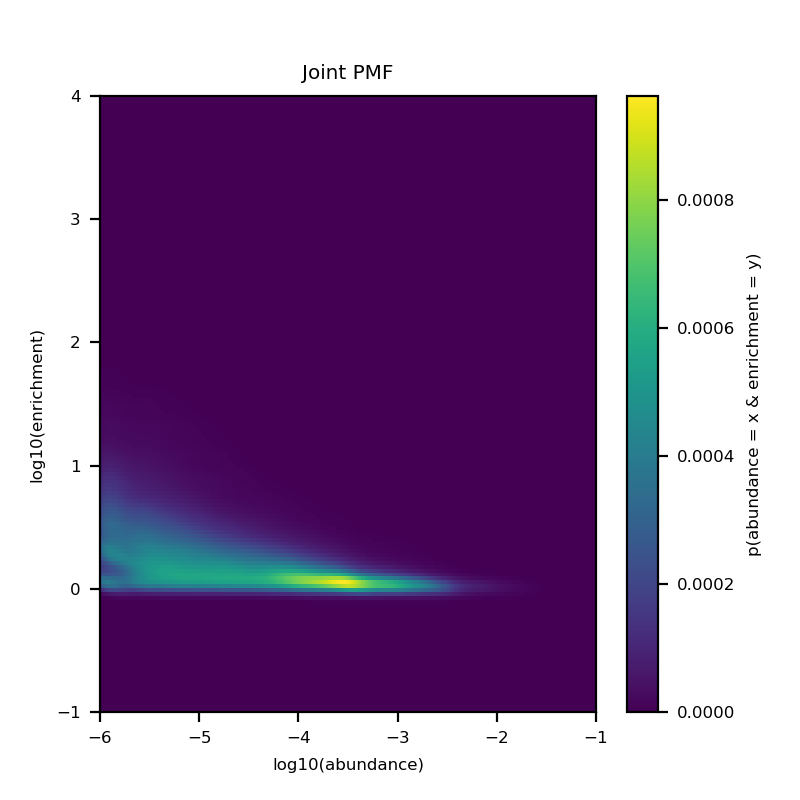

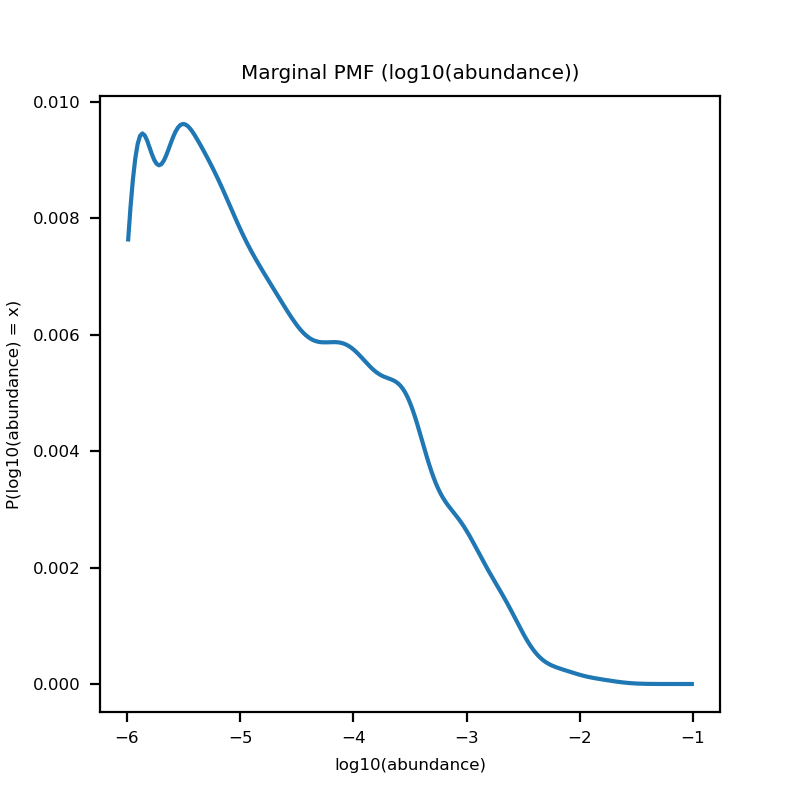

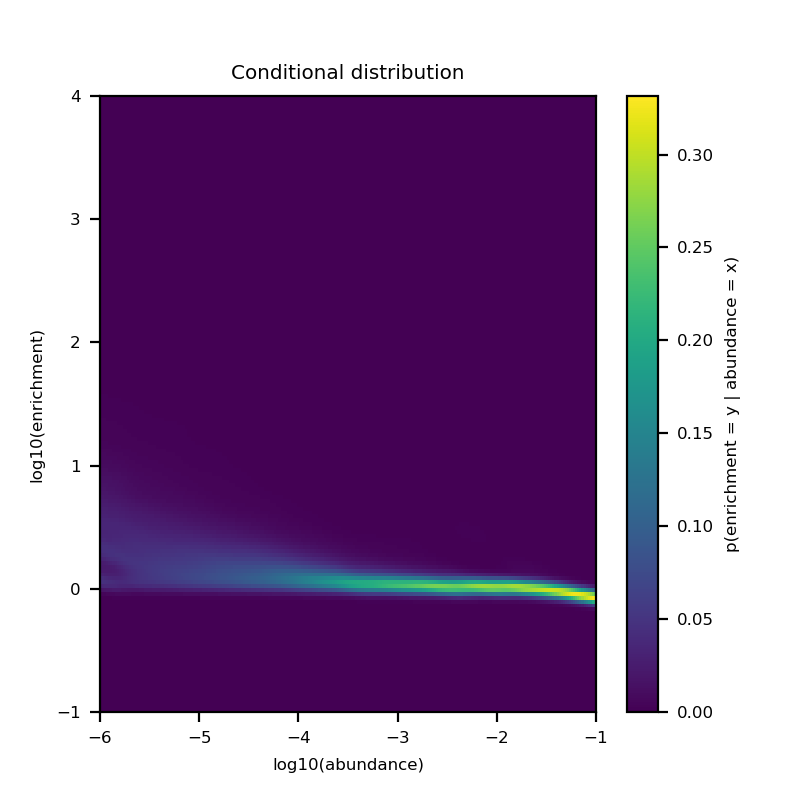

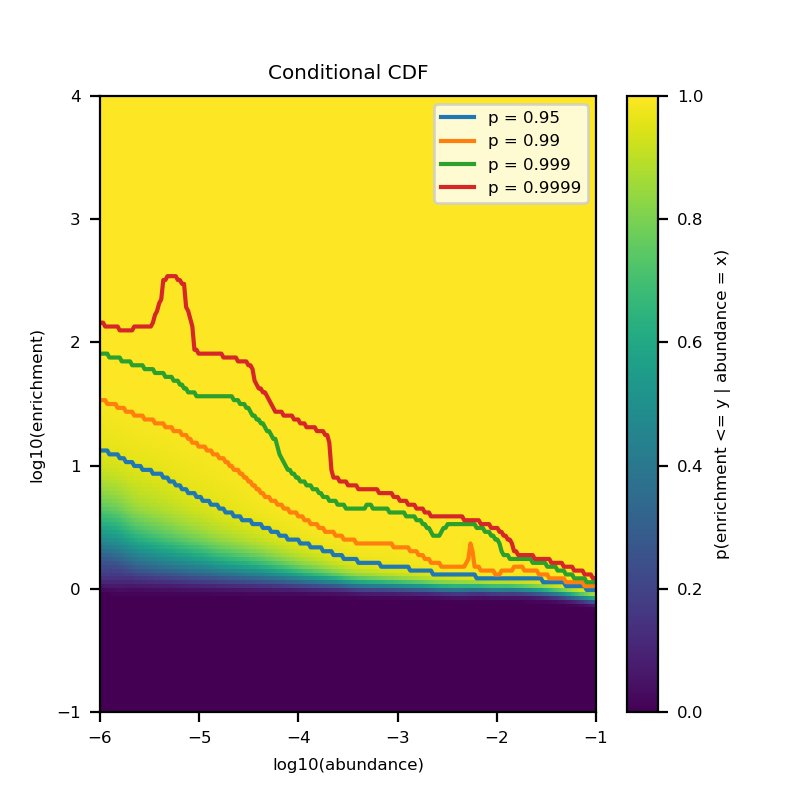

In [30]:
plt.show()

In [31]:
abundances = np.linspace(-6, -1, 6*40)
enrichments = np.linspace(-1, 4, 4*40)

xx, yy = np.meshgrid(abundances, enrichments)

zz = cond_ecdf.spline.ev(xx, yy)

pd.DataFrame({'log10(abundance)': xx.flat, 'log10(enrichment)': yy.flat, 'probability': zz.flat}).to_csv(
    'results/tables/figures/null_model/cond_ecdf.csv', index=False)

In [32]:
# cond_ecdf_path = f'results/tables/cdr3/enrichment/null/ecdf.pickle'
# nbseq.utils.mkdirp_file(cond_ecdf_path)
# with open(cond_ecdf_path, 'wb') as f:
#     import pickle
#     pickle.dump(cond_ecdf, f)